# K-Medoids++, K-Means++, and Shape Clustering

Guilherme Franca <guifranca@gmail.com>, 08/15/2016

Abstract: We implement K-Medoids algorithm and compare it to $K$-Means. We use the same idea as $K$-means++ for initialization. We evaluate both algorithms in shape clustering.

This algorithm is very similar to $K$-means with the exception that instead of getting a mean of the points inside the cluster, we pick the *medoid*. A medoid is a data point whose average dissimilarity to all objects in the cluster is minimal. In other words, it's the closest data point to the center of the data in that cluster.

Compared to $K$-means it is more robust to noise and to outliers.

The algorithm is described as follows. Consider a distance function $\mathcal{V}(x_i, x_j)$
between data points $X = \{x_i\}_{i=1}^N$. Let
$$
z_{nk} = \begin{cases}
1 & \mbox{if $x_n \in C_k$} \\
0 & \mbox{otherwise}
\end{cases}
$$
where $C_k$, $k=1,\dotsc,K$, represents the $k$th cluster. We want to minimize the cost function
$$
J = \dfrac{1}{2}\sum_{n=1}^N \sum_{k=1}^K z_{nk} \mathcal{V}(x_n, m_k)
$$
where $m_k$ is the $k$th medoid of cluster $k$. We do this as follows:
    
1. Given a data set $X$ compute the distance matrix $D \in \mathbb{R}^{N \times N}$ between data points.
2. Initialize medoids $\{m_1, \dotsc, m_K\}$.
3. $Z$-update: 
$$
z_{nk} = \begin{cases} 
1 & \mbox{ if $k = \mbox{argmin}_{j} \mathcal{V}(x_n, m_j)$ } \\ 
0 & \mbox{otherwise}
\end{cases}
$$

4. $M$-update:
$$
m_k = \mbox{argmin}_{x_l \in C_k}\left\{ \dfrac{1}{n_k} \sum_{x_i \in C_k} \mathcal{V}(x_l,x_i)\right\}
$$
5. Repeat 3 and 4 until convergence.

Notice that we just need to compute distance between data points, thus we can compute a distance matrix $D_{ij} = \mathcal{V}(x_i, x_j)$ and implement this algorithm just working with the indices of the data points.

Moreover, we can choose the initialization step 2 in the same way as $K$-means++. 

This implementation can be found on file **kmedoids.py**.
    

## Comparison $K$-Medoids and $K$-Means for Gaussian Clusters

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import datasets
from sklearn import metrics

import kmedoids
import kmeans

In [68]:
# artificial data from normal distribution
mean = np.array([0,0])
cov = np.array([[4,0], [0,1]])
data1 = np.random.multivariate_normal(mean, cov, 200)
mean = np.array([3,5])
cov = np.array([[1,0.8], [0.8,2]])
data2 = np.random.multivariate_normal(mean, cov, 200)
mean = np.array([-2,3])
cov = np.array([[0.5,0], [0,0.5]])
data3 = np.random.multivariate_normal(mean, cov, 200)
data = np.concatenate((data1, data2, data3))
labels = np.concatenate(([0]*200, [1]*200, [2]*200))

In [69]:
K=3
D = kmedoids.euclidean(data)
J, M = kmedoids.kmedoids(K, D)

In [70]:
K=3
JJ, MM = kmeans.kmeans(K, data)

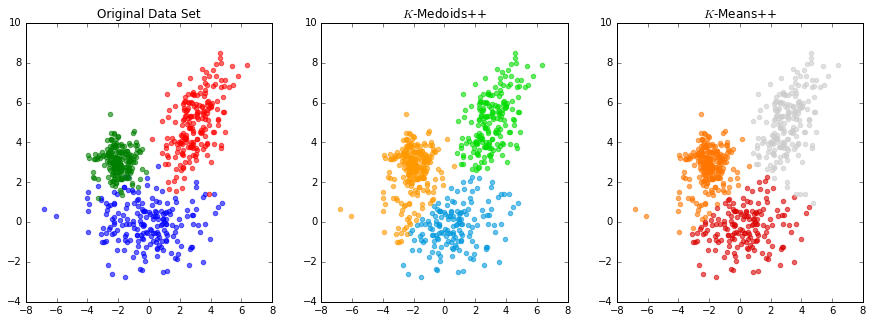

In [71]:
%matplotlib inline

fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(131)
ax.scatter(data1[:,0], data1[:,1], color='b', alpha=.6)
ax.scatter(data2[:,0], data2[:,1], color='r', alpha=.6)
ax.scatter(data3[:,0], data3[:,1], color='g', alpha=.6)
ax.set_title('Original Data Set')

ax = fig.add_subplot(132)
cc = cm.spectral(np.linspace(0.3,0.8,K))
for k in range(K):
    idx = np.where(J==k)
    ax.scatter(data[:,0][idx], data[:,1][idx], color=cc[k], alpha=.6)
ax.set_title('$K$-Medoids++')
    
ax = fig.add_subplot(133)
cc = cm.spectral(np.linspace(0.81,1,K))
for k in range(K):
    idx = np.where(JJ==k)
    ax.scatter(data[:,0][idx], data[:,1][idx], color=cc[k], alpha=.6)
ax.set_title('$K$-Means++')

In [72]:
# mutual information (unnormalized)
print metrics.mutual_info_score(labels, J)
print metrics.mutual_info_score(labels, JJ)

# normalized NMI
print metrics.normalized_mutual_info_score(labels, J)
print metrics.normalized_mutual_info_score(labels, JJ)

# adjusted MI, this is not so common
print metrics.adjusted_mutual_info_score(labels, J)
print metrics.adjusted_mutual_info_score(labels, JJ)

# ARI (adjusted Rand Index)
print metrics.adjusted_rand_score(labels, J)
print metrics.adjusted_rand_score(labels, JJ)

0.82388460701
0.841102735009
0.756525965941
0.769195959161
0.749167509403
0.764888108078
0.739549108207
0.786736420078


In this case both $K$-medoids and $K$-means seems to be clustering decently, but $K$-means seems slightly superior.

In [75]:
print kmedoids.missclassification_error(labels, J)
print kmedoids.missclassification_error(labels, JJ)

0.1
0.0783333333333


In [76]:
nrange = range(10, 300, 10)
kmedoids_metric, kmeans_metric = kmedoids.gauss_eval(kmedoids.euclidean, metrics.normalized_mutual_info_score, nrange, num_avg=5)

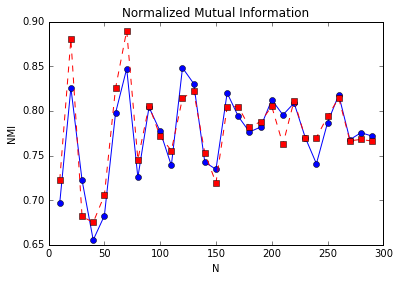

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(nrange, kmedoids_metric, '-o', color='b')
ax.plot(nrange, kmeans_metric, '--s', color='r')
ax.set_title('Normalized Mutual Information')
ax.set_xlabel('N')
ax.set_ylabel('NMI')

In [78]:
nrange = range(10, 200, 10)
kmedoids_metric, kmeans_metric = kmedoids.gauss_eval(kmedoids.euclidean, kmedoids.missclassification_error, nrange, num_avg=5)

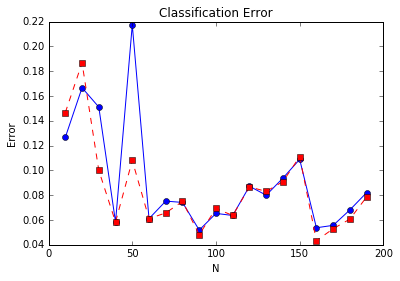

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(nrange, kmedoids_metric, '-o', color='b')
ax.plot(nrange, kmeans_metric, '--s', color='r')
ax.set_title('Classification Error')
ax.set_xlabel('N')
ax.set_ylabel('Error')

## Comparing $K$-Medoids and $K$-Means for Iris Dataset

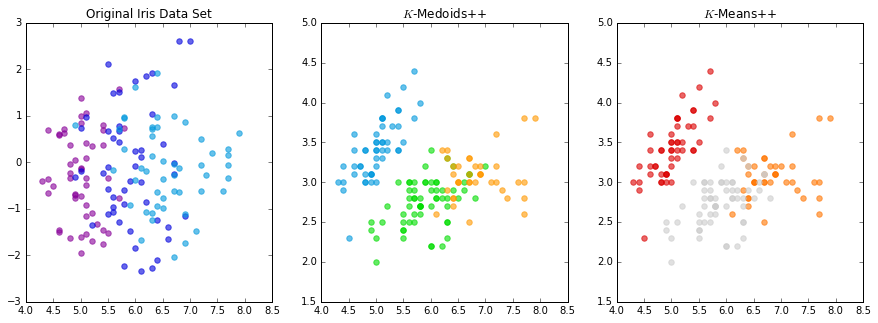

In [36]:
# using the iris data set

iris = datasets.load_iris()
iris_data = iris.data
iris_label = iris.target

K = 3
J, M = kmedoids.kmedoids(K, kmedoids.euclidean(iris_data))
JJ, MM = kmeans.kmeans(K, iris_data)


fig = plt.figure(figsize=(15,5))

s = 30 #marker size
ax = fig.add_subplot(131)
cc = cm.spectral(np.linspace(0.1, 0.3, K))
for k in range(K):
    idx = np.where(iris_label==k)
    ax.scatter(iris_data[:,0][idx], data1[:,1][idx], color=cc[k], alpha=.6, s=s)
ax.set_title('Original Iris Data Set')

ax = fig.add_subplot(132)
cc = cm.spectral(np.linspace(0.3,0.8,K))
for k in range(K):
    idx = np.where(J==k)
    ax.scatter(iris_data[:,0][idx], iris_data[:,1][idx], color=cc[k], alpha=.6, s=s)
ax.set_title('$K$-Medoids++')
    
ax = fig.add_subplot(133)
cc = cm.spectral(np.linspace(0.81,1,K))
for k in range(K):
    idx = np.where(JJ==k)
    ax.scatter(iris_data[:,0][idx], iris_data[:,1][idx], color=cc[k], alpha=.6, s=s)
ax.set_title('$K$-Means++')

In [37]:
labels = iris_label

# mutual information (unnormalized)
print metrics.mutual_info_score(labels, J)
print metrics.mutual_info_score(labels, JJ)

# normalized NMI
print metrics.normalized_mutual_info_score(labels, J)
print metrics.normalized_mutual_info_score(labels, JJ)

# adjusted MI, this is not so common
print metrics.adjusted_mutual_info_score(labels, J)
print metrics.adjusted_mutual_info_score(labels, JJ)

# ARI (adjusted Rand Index)
print metrics.adjusted_rand_score(labels, J)
print metrics.adjusted_rand_score(labels, JJ)

0.82559109761
0.809039279547
0.758205727819
0.741932298463
0.748372312532
0.733117988676
0.730238272283
0.716342112684


In this example sometimes $K$-medoids does slightly better than $K$-means, but not always.

In [38]:
print kmedoids.missclassification_error(labels, J)
print kmedoids.missclassification_error(labels, JJ)

0.106666666667
0.113333333333


## Comparing $K$-Medoids and $K$-Means for Digits Dataset

In [39]:
# now let us use the digits data set

digits = datasets.load_digits()
images = digits.images
print images.shape

(1797, 8, 8)


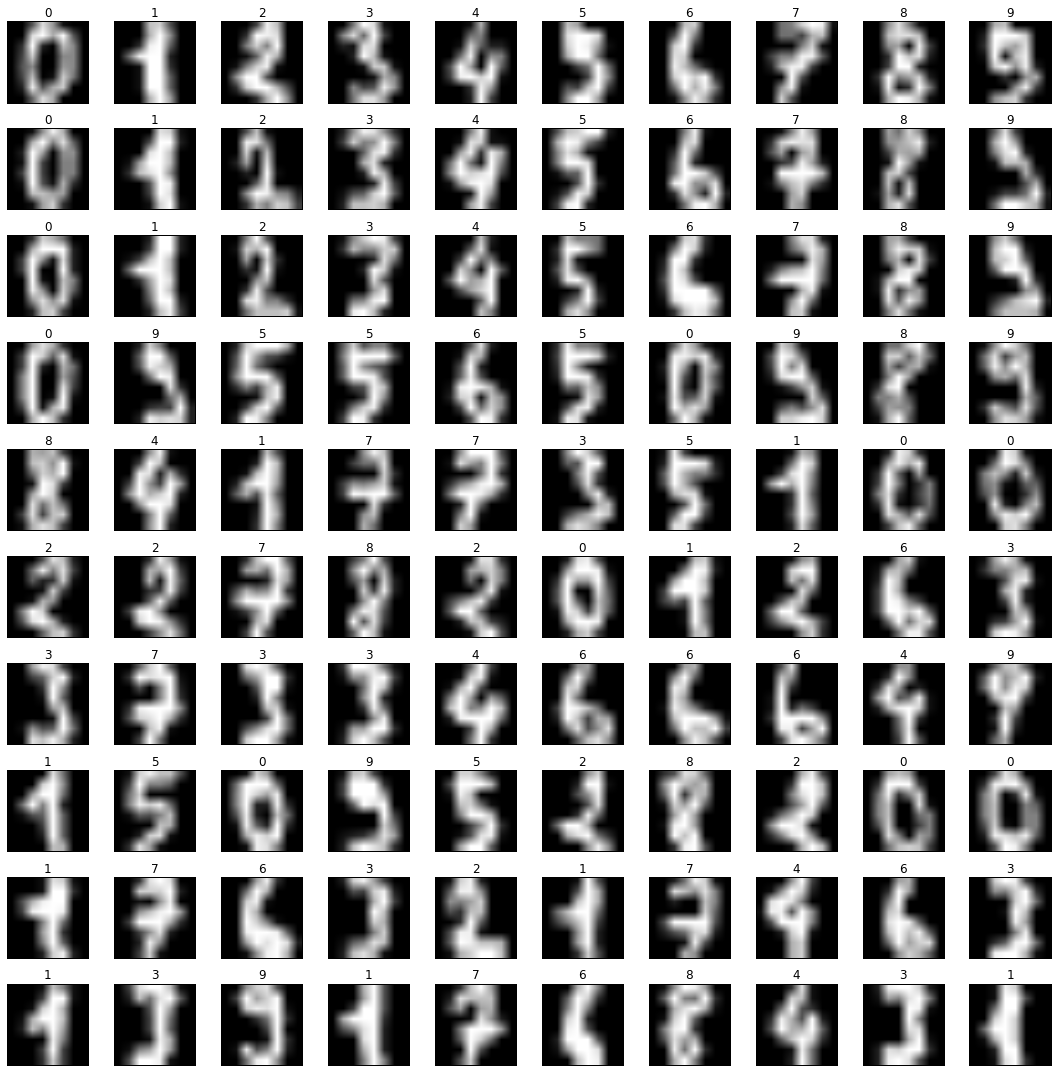

In [40]:
# showing a sample of the figures
fig = plt.figure(figsize=(15,15))
for i, img in enumerate(images[:100]):
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(img, cmap=cm.gray)
    ax.set_title("%i" % digits.target[i])
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

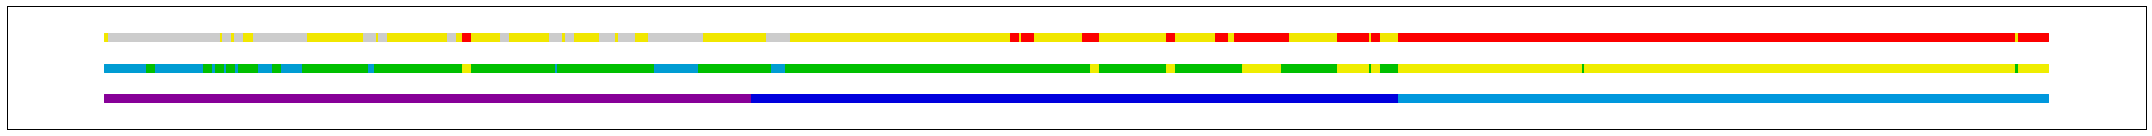

In [80]:
# picking some digits
n = [170, 170, 170]
d = [1, 2, 3]
labels = np.concatenate([[i]*x for i, x in enumerate(n)])

data = np.concatenate([images[np.where(digits.target==i)][:m].reshape((m, 64)) 
                       for i, m in zip(d, n)])

# just to plot points and visualize data
coords = np.array([i for i in range(len(data))])

J, M = kmedoids.kmedoids(len(n), kmedoids.euclidean(data))
JJ, MM = kmeans.kmeans(len(n), data)

fig = plt.figure(figsize=(30,2))
ax = fig.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])
cc = cm.spectral(np.linspace(0.1, 0.3, len(n)))
s = 50
for k in range(len(n)):
    idx = np.where(labels==k)[0]
    ax.scatter(coords[idx], [0]*len(idx), color=cc[k], s=s, marker='s')

cc = cm.spectral(np.linspace(0.31, 0.7, len(n)))
for k in range(len(n)):
    idx = np.where(J==k)[0]
    ax.scatter(coords[idx], [1]*len(idx), color=cc[k], s=s, marker='s')

cc = cm.spectral(np.linspace(0.71, 1, len(n)))
for k in range(len(n)):
    idx = np.where(JJ==k)[0]
    ax.scatter(coords[idx], [2]*len(idx), color=cc[k], s=s, marker='s')

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(-1, 3)
fig.tight_layout()


The above figure show each a colored dot for each digit category. The bottom dots are the true digits, the second line of dots are the digits clustered by $K$-medoids++, and the top line of dots using $K$-means++.

In [81]:
# mutual information (unnormalized)
print metrics.mutual_info_score(labels, J)
print metrics.mutual_info_score(labels, JJ)

# normalized NMI
print metrics.normalized_mutual_info_score(labels, J)
print metrics.normalized_mutual_info_score(labels, JJ)

# adjusted MI, this is not so common
print metrics.adjusted_mutual_info_score(labels, J)
print metrics.adjusted_mutual_info_score(labels, JJ)

# ARI (adjusted Rand Index)
print metrics.adjusted_rand_score(labels, J)
print metrics.adjusted_rand_score(labels, JJ)

0.53789009074
0.545050533676
0.512892878519
0.522656432876
0.48776742677
0.49430784422
0.469554119362
0.473995250642


From the above indexes it seems that $K$-means is doing a better job than $K$-medoids.


## Evaluating $K$-Medoids++ and $K$-Means++ on MNIST

Now we evaluate the above clustering more systematically. We analyse several metric indices against $N$, the size of the data set. We also run the algorithm several times and take the average result.


In [82]:

numbers = [1, 2, 3]
nrange = range(10, 170, 10)

kmedoids_metric, kmeans_metric = kmedoids.mnist_eval(kmedoids.euclidean, metrics.normalized_mutual_info_score, numbers, nrange, num_avg=10)

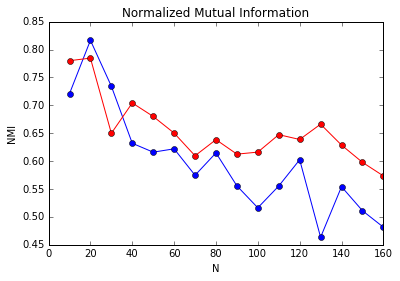

In [83]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(nrange, kmedoids_metric, '-o', color='b')
ax.plot(nrange, kmeans_metric, '-o', color='r')
ax.set_title('Normalized Mutual Information')
ax.set_xlabel('N')
ax.set_ylabel('NMI')

In [86]:
kmedoids_metric, kmeans_metric = kmedoids.mnist_eval(kmedoids.euclidean, metrics.adjusted_rand_score, numbers, nrange, num_avg=5)

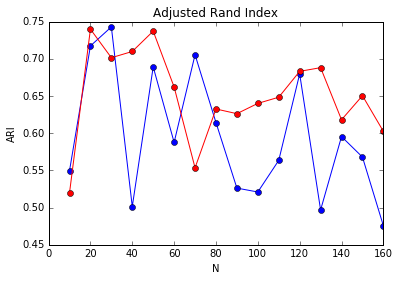

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(nrange, kmedoids_metric, '-o', color='b')
ax.plot(nrange, kmeans_metric, '-o', color='r')
ax.set_title('Adjusted Rand Index')
ax.set_xlabel('N')
ax.set_ylabel('ARI')

We can see that for large ammounts of data the quality of the clustering in both algorithms are not so good.

In [89]:
km_hom, kmm_hom = kmedoids.mnist_eval(kmedoids.euclidean, metrics.homogeneity_score, numbers, nrange, num_avg=10)
km_comp, kmm_comp = kmedoids.mnist_eval(kmedoids.euclidean, metrics.completeness_score, numbers, nrange, num_avg=10)

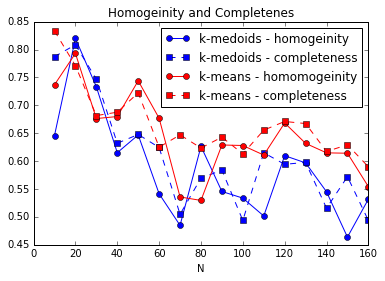

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(nrange, km_hom, '-o', color='b', label='k-medoids - homogeinity')
ax.plot(nrange, km_comp, '--s', color='b', label='k-medoids - completeness')
ax.plot(nrange, kmm_hom, '-o', color='r', label='k-means - homomogeinity')
ax.plot(nrange, kmm_comp, '--s', color='r', label='k-means - completeness')
ax.set_title('Homogeinity and Completenes')
ax.set_xlabel('N')
ax.legend()

In [93]:
numbers = [1, 2, 3]
nrange = range(10, 170, 10)

kmedoids_metric, kmeans_metric = kmedoids.mnist_eval(kmedoids.euclidean, kmedoids.missclassification_error, numbers, nrange, num_avg=20)

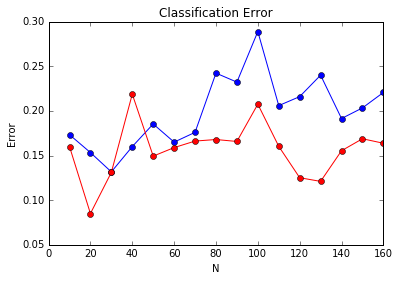

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(nrange, kmedoids_metric, '-o', color='b')
ax.plot(nrange, kmeans_metric, '-o', color='r')
ax.set_title('Classification Error')
ax.set_xlabel('N')
ax.set_ylabel('Error')

In [112]:
reload(kmedoids)

<module 'kmedoids' from 'kmedoids.py'>

In [113]:
numbers = [1, 2, 3]
nrange = range(10, 170, 10)

metric = kmedoids.mnist_eval_sklearn(kmedoids.missclassification_error, numbers, nrange)

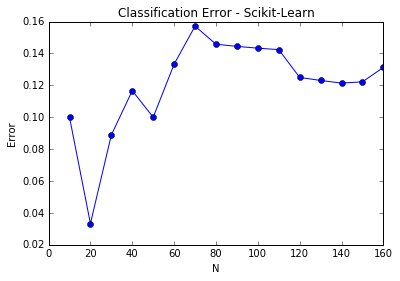

In [114]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(nrange, metric, '-o', color='b')
ax.set_title('Classification Error - Scikit-Learn')
ax.set_xlabel('N')
ax.set_ylabel('Error')

In [116]:
numbers = [1, 2, 3]
nrange = range(10, 170, 10)

metric = kmedoids.mnist_eval_sklearn(metrics.normalized_mutual_info_score, numbers, nrange)

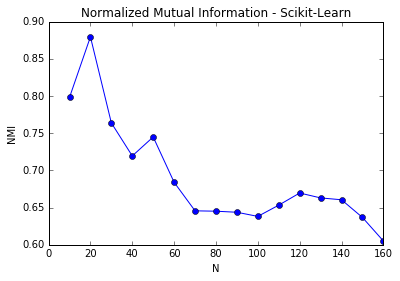

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(nrange, metric, '-o', color='b')
ax.set_title('Normalized Mutual Information - Scikit-Learn')
ax.set_xlabel('N')
ax.set_ylabel('NMI')